# *Tutorial: Chromatic Aberration with a Singlet Lens 🌈*
**Author:** Dong-Ha Shin | **Last Updated:** 2025-03-19

This jupyter notebook demonstrates how to simulate chromatic aberration with a singlet lens using `Pado`. Through this tutorial, you will learn how to model wavelength-dependent focusing and visualize the resulting point spread functions (PSFs)

In [1]:
cd ../..

c:\Users\PC\Desktop\pado


In [2]:
pwd

'c:\\Users\\PC\\Desktop\\pado'

## 🌊 **Step 1: Import Pado**
First, you should import Pado. Make sure to install all the dependency :) 

In [3]:
import pado
import torch
import matplotlib.pyplot as plt

from pado.math import nm, um

## **💡Step 2: Everything Starts From Light**

The fundamental element of `Pado` is `light`. As we want to simulate how light wave interacts with other optical elements and propagate in free space, we should start from defining light. Based on wave optics, we represent light wave as a 2D complex-valued field on a virtual plane. That is, each complex-valued element in the array represents the phase and ampiltude of light wave at that spatial location.

We should first define the resolution of the light we want to simulate as:

In [4]:
R = 1000  # number of rows
C = 1000  # number of columns
pitch = 2*um  # physical size of each pixel in [m]
wvl = [660*nm, 521*nm, 445*nm]  # wavelengths of the light in [m]
dim = (1, 3, R, C)  # dimension of the light [batch, channel, row, column], 3 channels for R-G-B
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Then, we define the light. This can be easily done using the class `Light`. By default, it initializes the amplitude as one and the phase as zero, resulting in a planar wave. Note that we  store the data in GPU here, so we supply 'cuda:0' for the device argument. We can visualize the content of light with the `visualize()` function. If you only want to see a specific channel, you can specify the channel like `light.visualize(c=0)`.

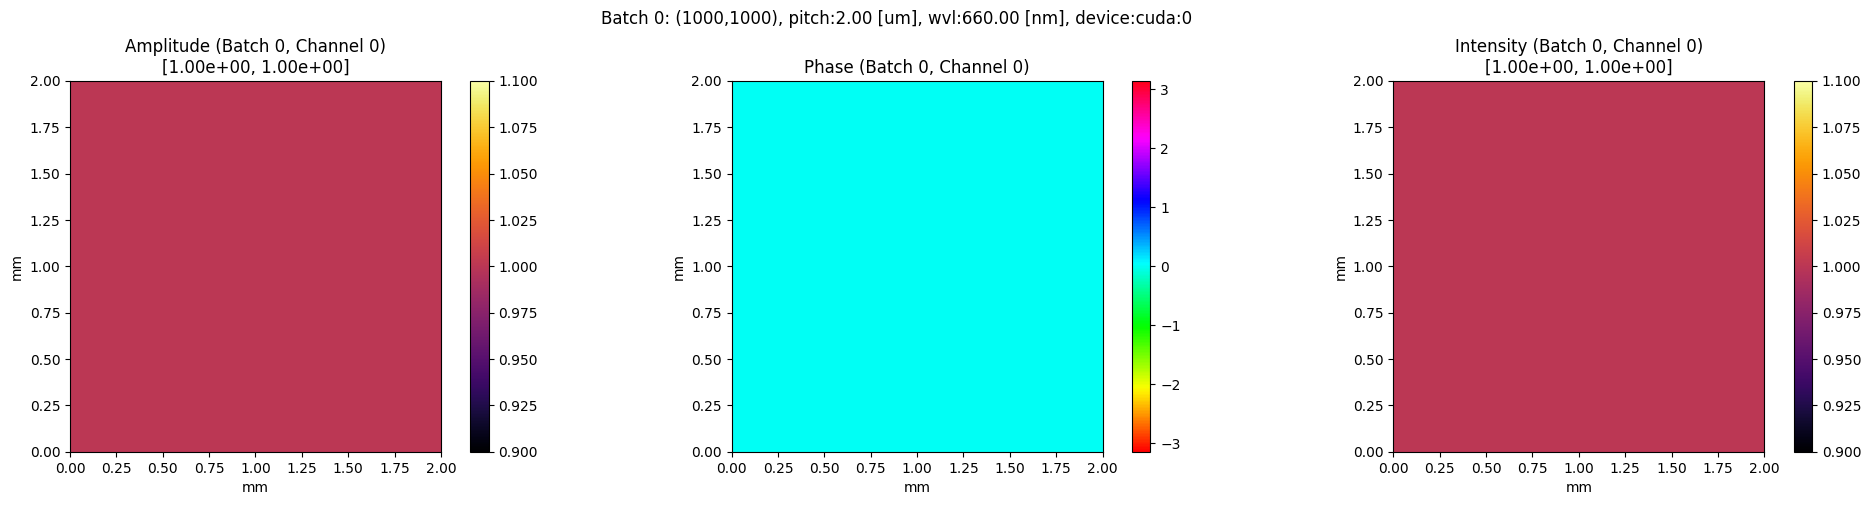

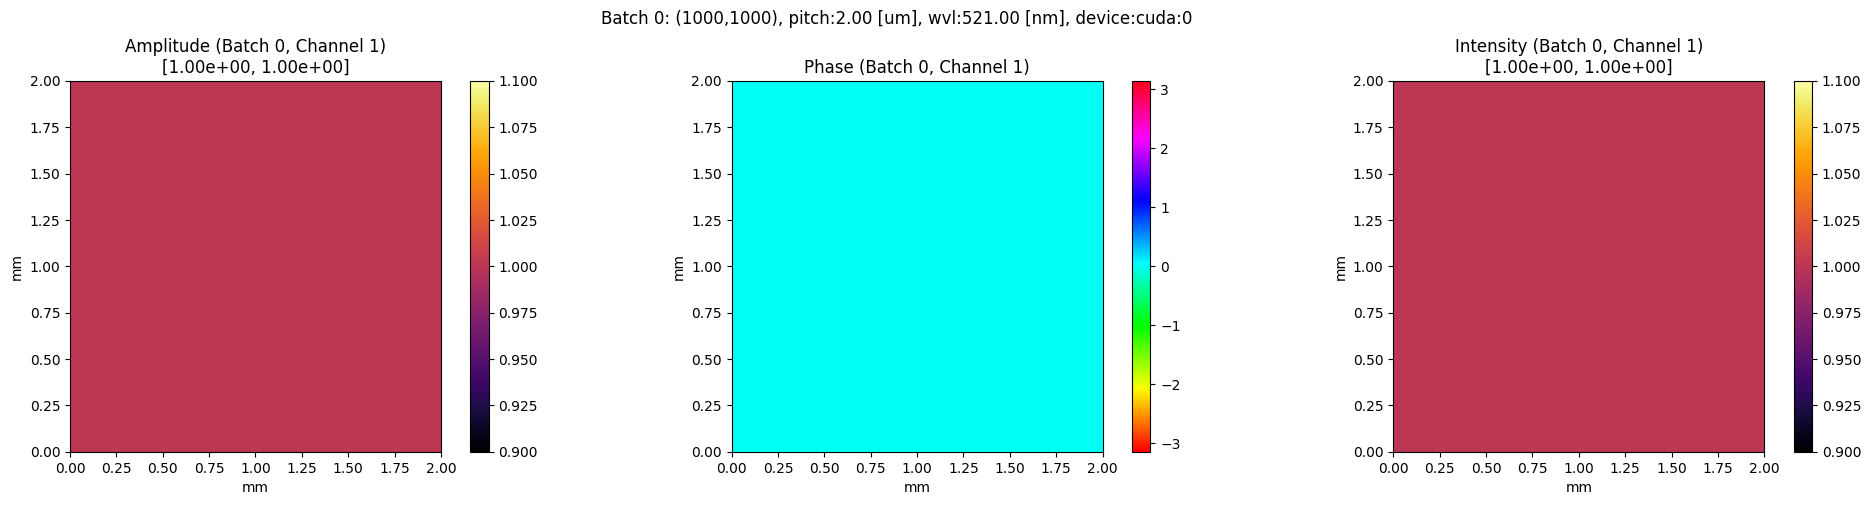

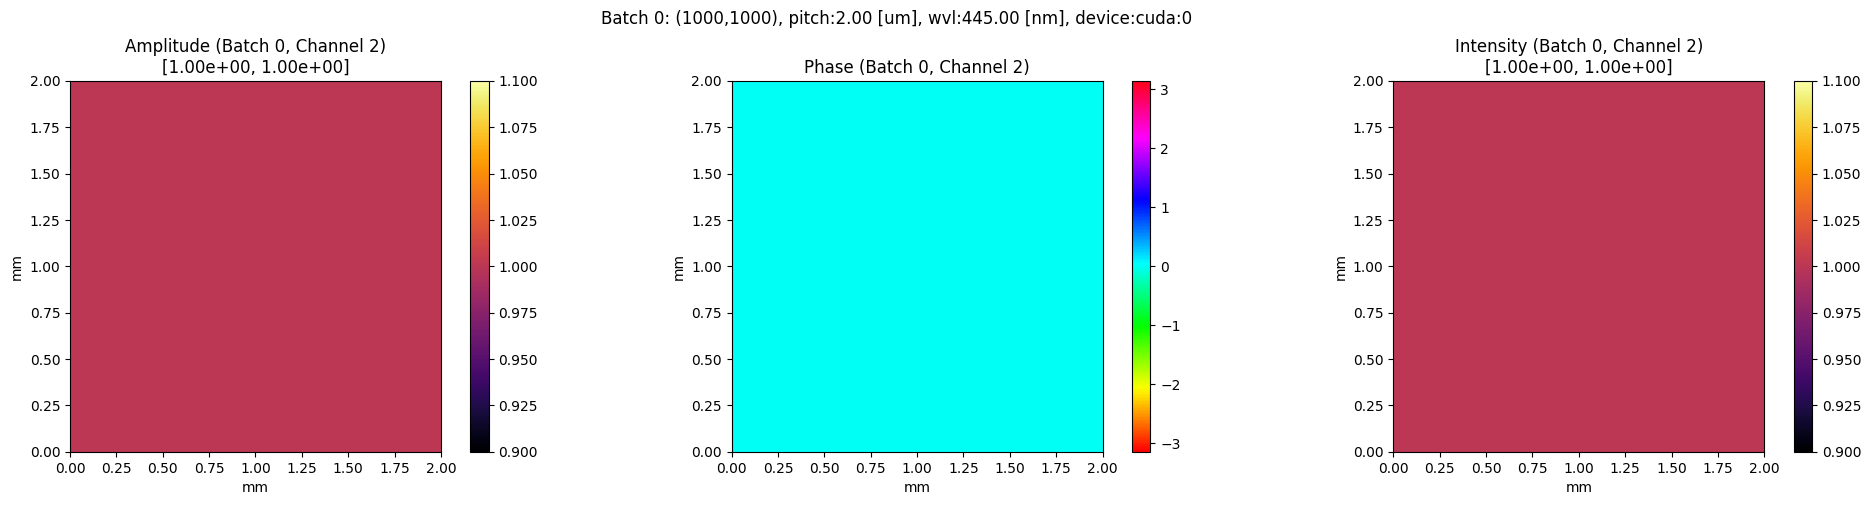

In [5]:
light = pado.light.Light(dim,pitch,wvl,device=device)
light.visualize()

## 🔍 **Step 3: Build Your Own Imaging/Display System**
In this tutorial, we will use a simple camera with a refractive lens and an aperture. Note that we provide various optical elements that can interact with and transform light wave. Let's first define the basic optical elements: lens and aperture.

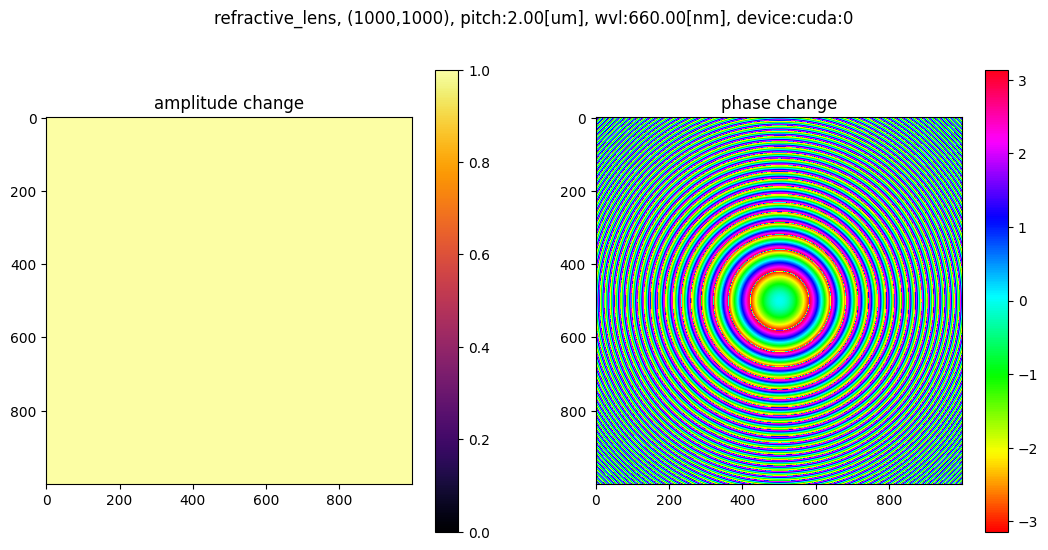

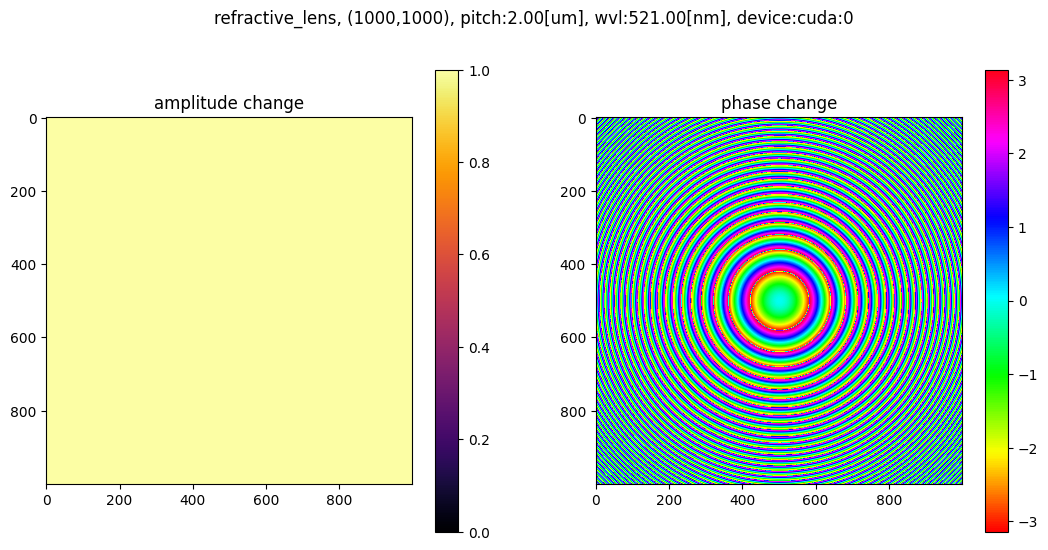

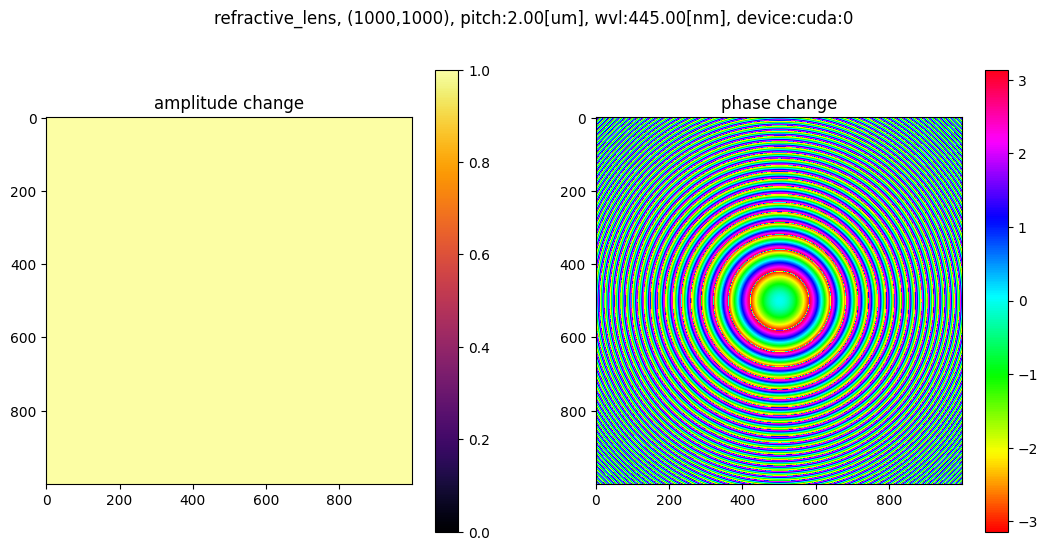

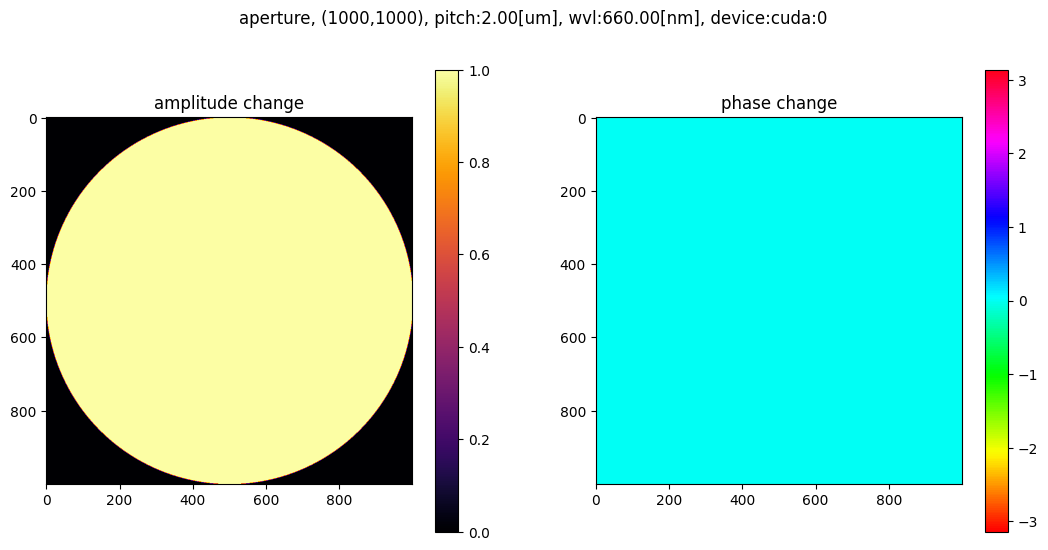

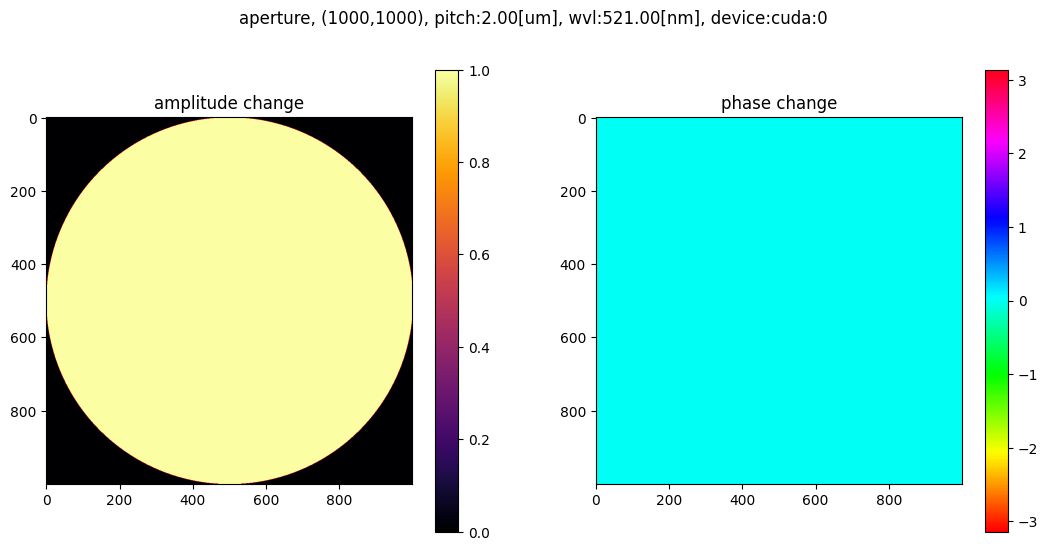

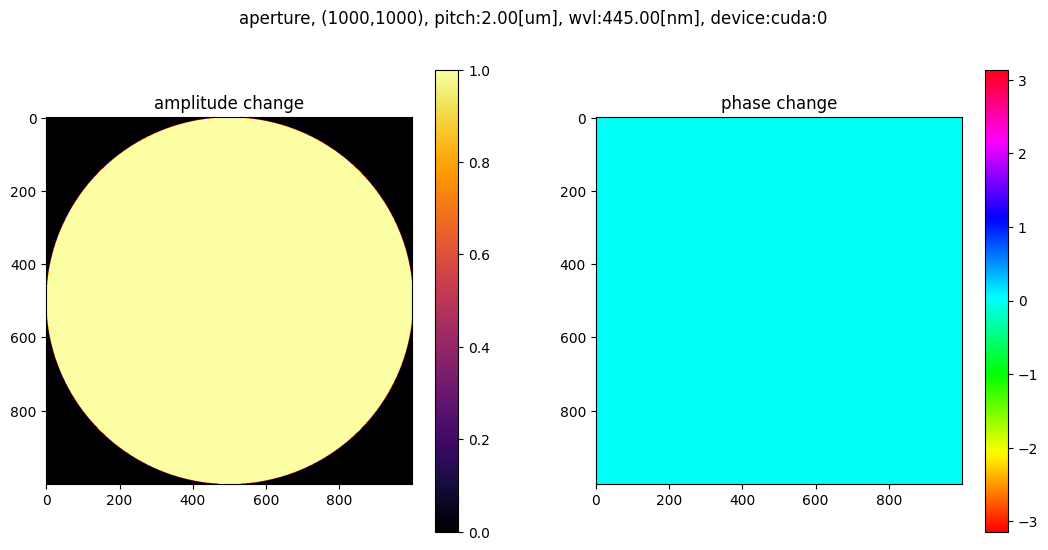

In [6]:
f = 50e-3  # focal length
lens = pado.optical_element.RefractiveLens(dim,pitch,f,wvl,device, designated_wvl=521*nm)
lens.visualize() 
aperture = pado.optical_element.Aperture(dim, pitch, R*pitch, 'circle', wvl,device)
aperture.visualize() 


Now, we want to simulate the point spread function (PSF) of this camera. In order to do this, we should use light, lens, aperture, and also propagator. The propagator computes how phase and amplitude of light changes after free-space propagation by a specific distance. Specifically, we use Fresnel propagator which is valid for short propagation distances.


In [7]:
prop = pado.propagator.Propagator('ASM')

Let's combine everything together and simulate the system's PSF now. Key here is the function `forward` that takes the light and outputs the light after interaction with either the optical element or the propagator.

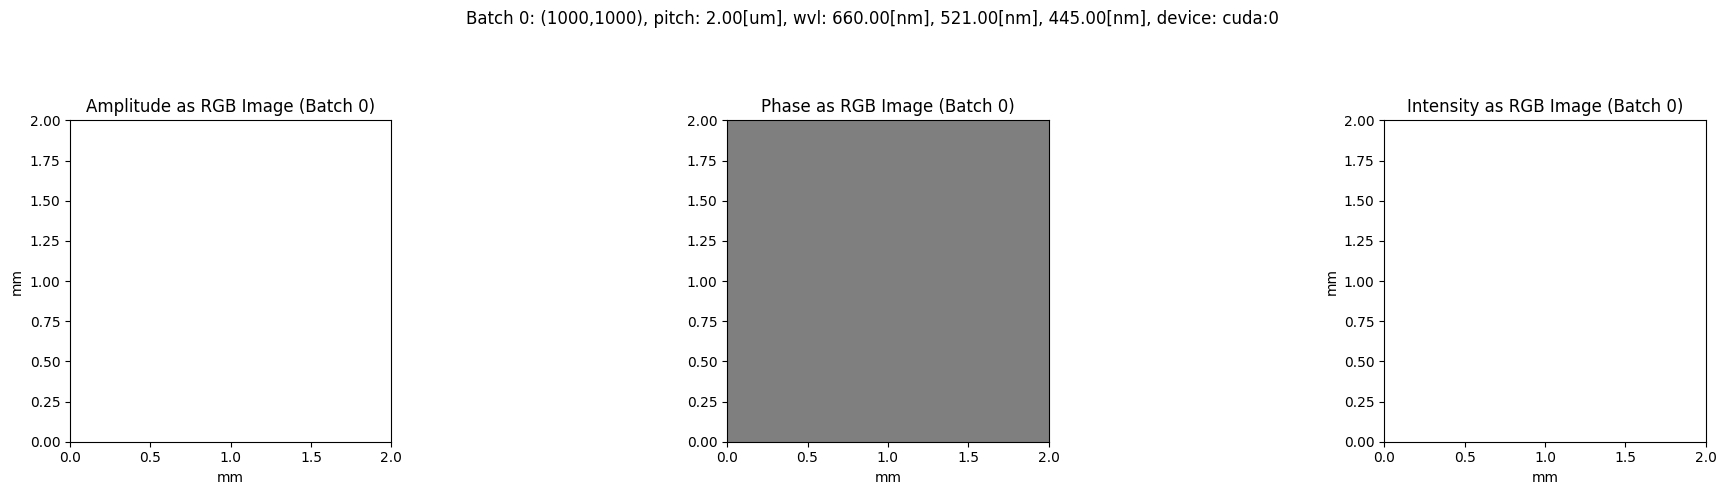

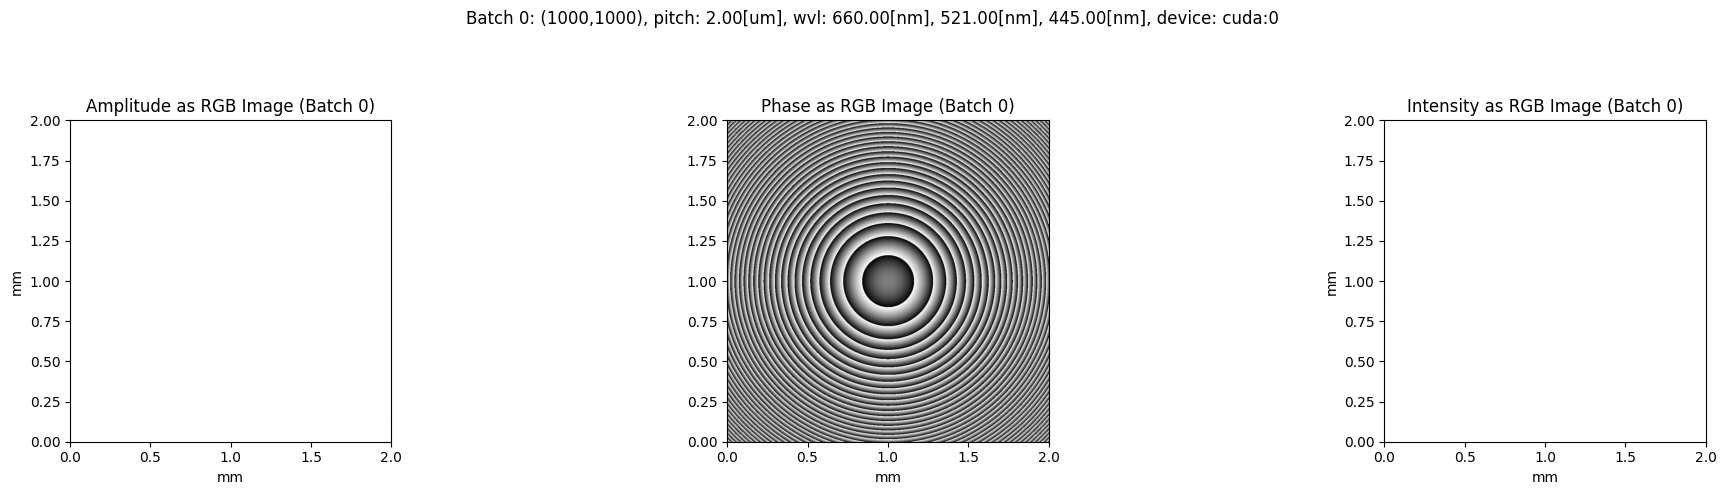

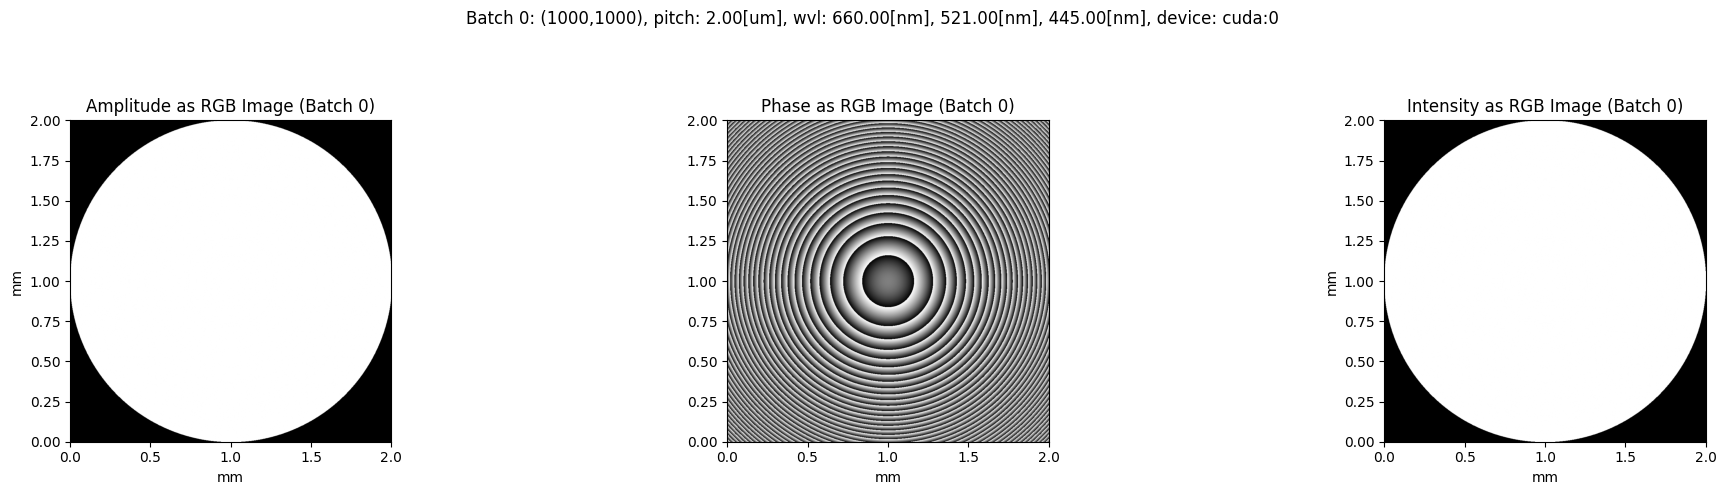

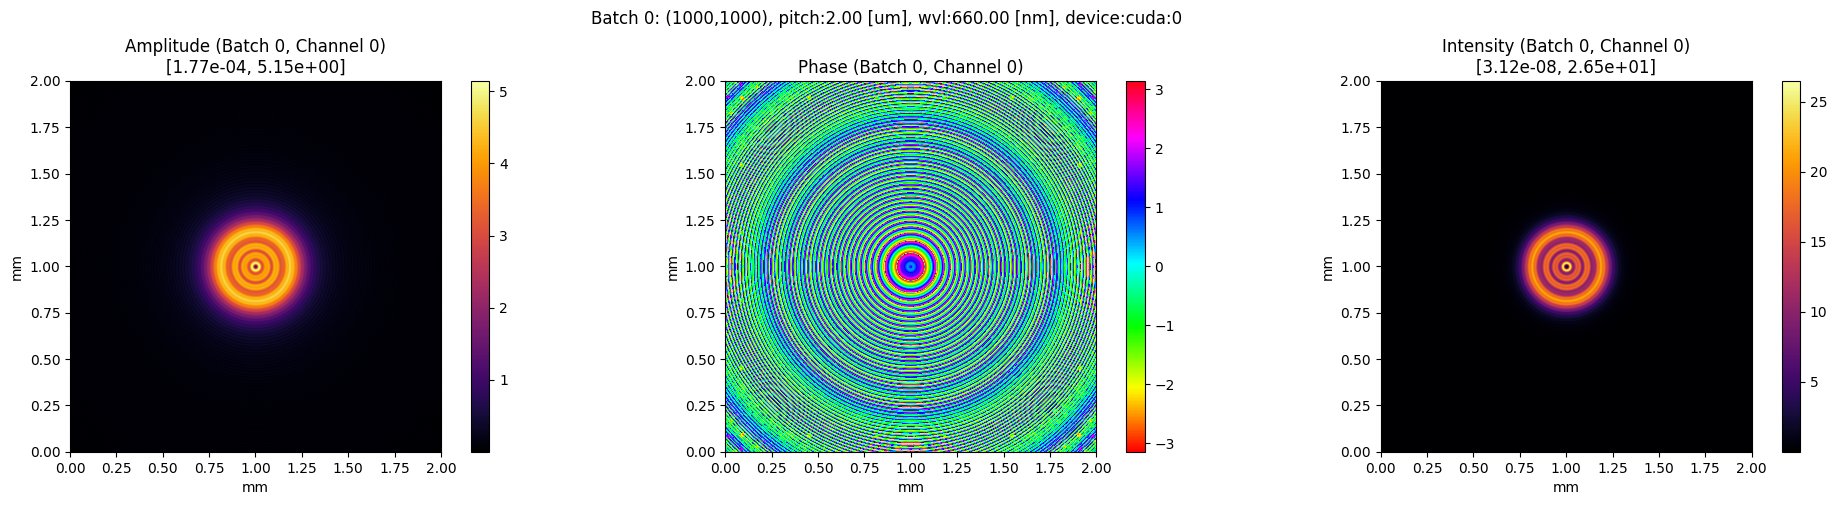

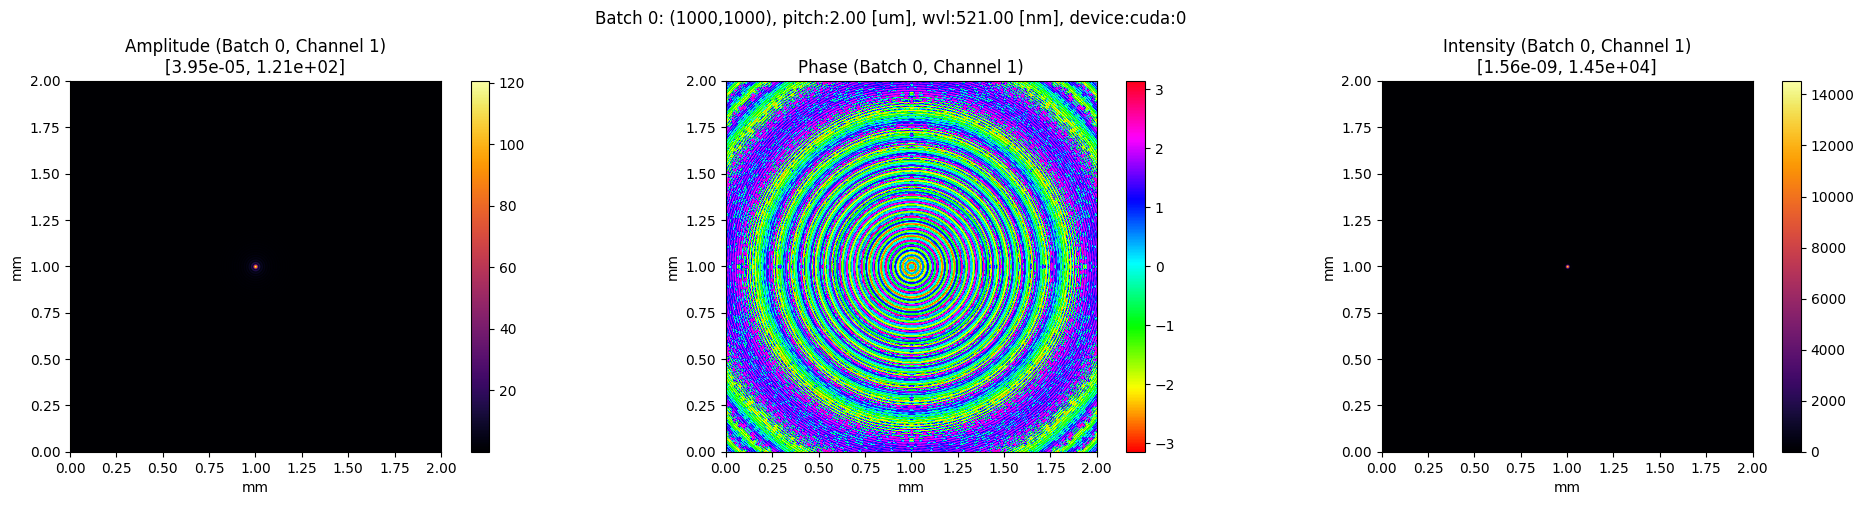

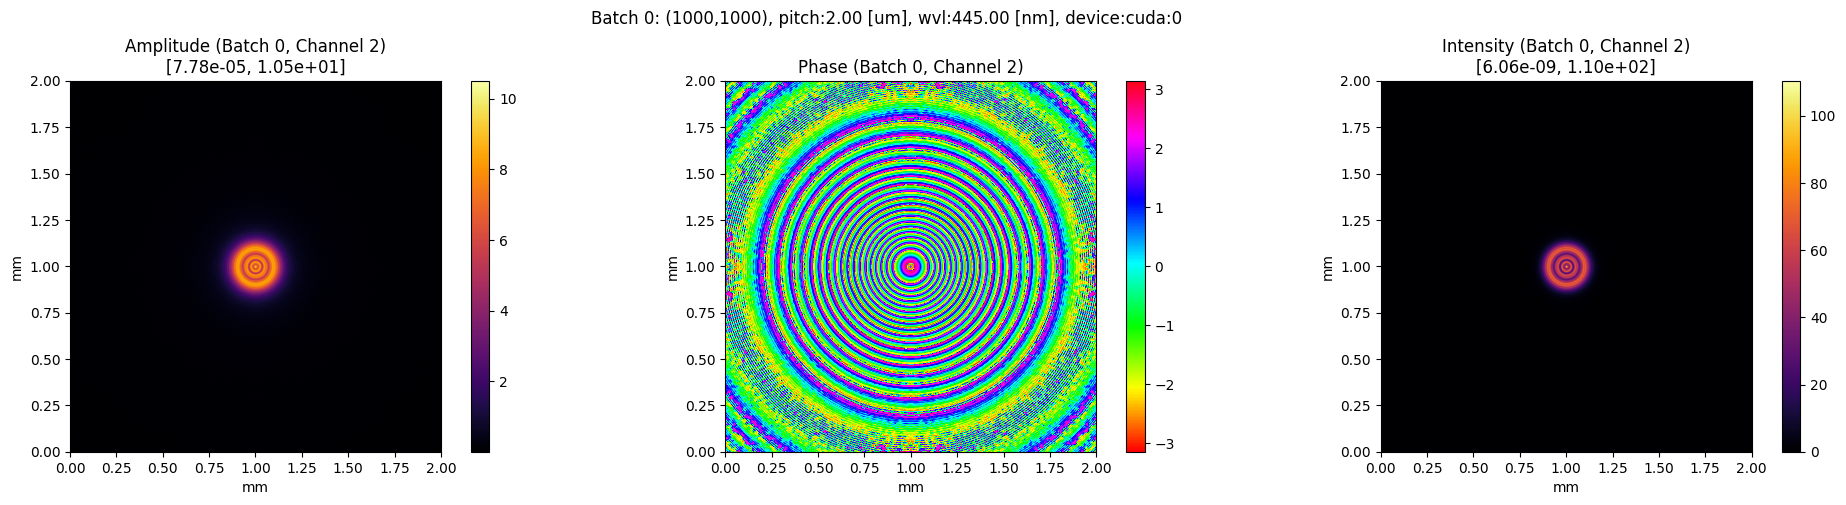

In [8]:
light.visualize_image() 

light_after_lens = lens.forward(light)
light_after_lens.visualize_image() 

light_after_aperture = aperture.forward(light_after_lens)
light_after_aperture.visualize_image() 

light_after_prop = prop.forward(light_after_aperture, f)
light_after_prop.visualize(uniform_scale=False)

The PSF is a diffraction-limited focused dot. 

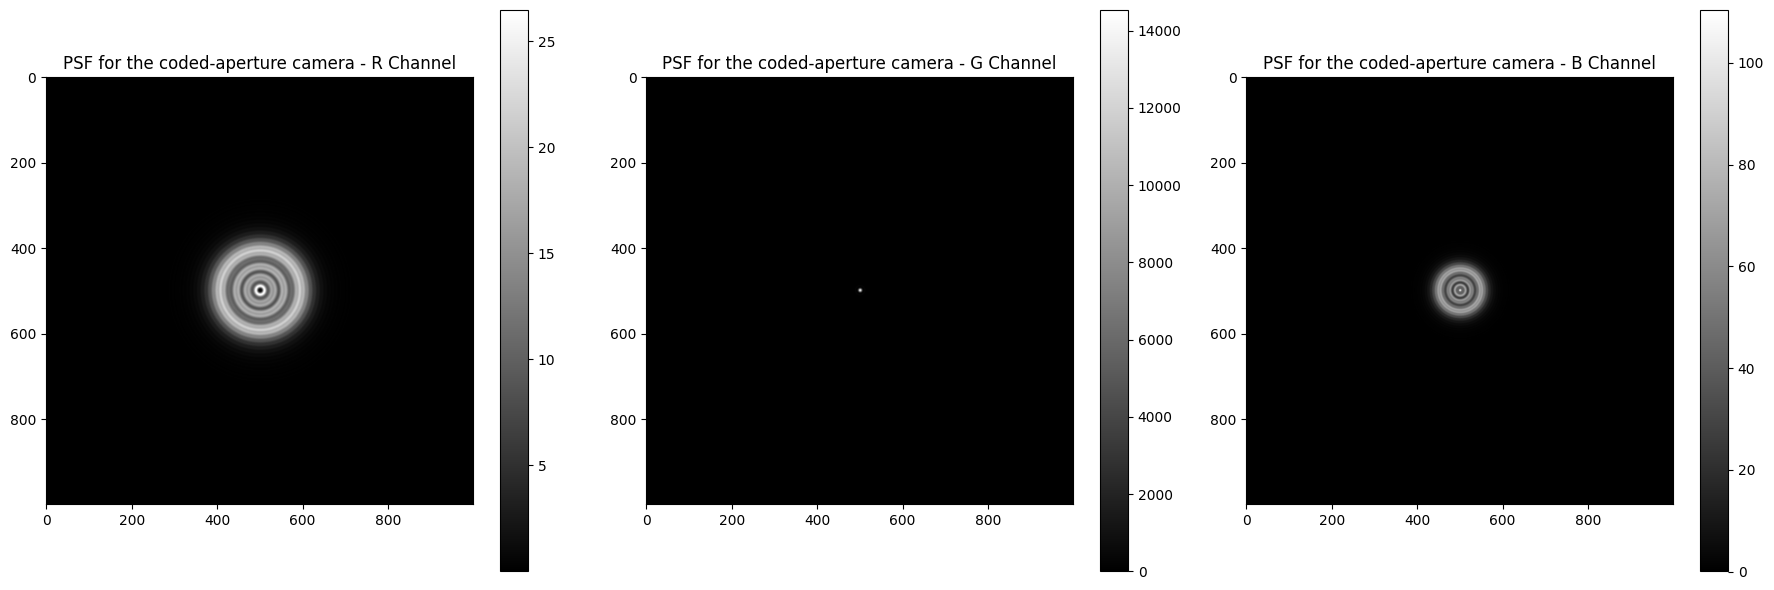

In [9]:
PSF = light_after_prop.get_intensity()
channels = [('R', 0), ('G', 1), ('B', 2)]

plt.figure(figsize=(18, 6)) 

for i, (color, idx) in enumerate(channels):
    plt.subplot(1, 3, i + 1) 
    PSF_channel = PSF[:, idx, ...].data.cpu().squeeze() 
    plt.imshow(PSF_channel, cmap='gray') 
    plt.colorbar() 
    plt.title(f'PSF for the coded-aperture camera - {color} Channel') 

plt.tight_layout() 
plt.show() 


## 📊 **Step 4: Rendering Pipeline**
Now, let's make the rendering pipeline as a function so that we can easily call it later. Here, we parameterize the render function with two input parameters of the distance from the lens to the sensor and the aperture's amplitude change profile.

In [10]:
def render(lens2sensor_d, aperture_amp_modulation):
    light = pado.light.Light(dim,pitch,wvl,device=device)
    light_after_lens = lens.forward(light)
    aperture.set_amplitude_change(aperture_amp_modulation)
    light_after_aperture = aperture.forward(light_after_lens)
    light_after_prop = prop.forward(light_after_aperture, lens2sensor_d)
    PSF = light_after_prop.get_intensity()
    return PSF

Let's see how the PSF change for the varying distance between the lens and the sensor

c:\Users\PC\Desktop\pado\pado\propagator.py:460: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, device=light.device)


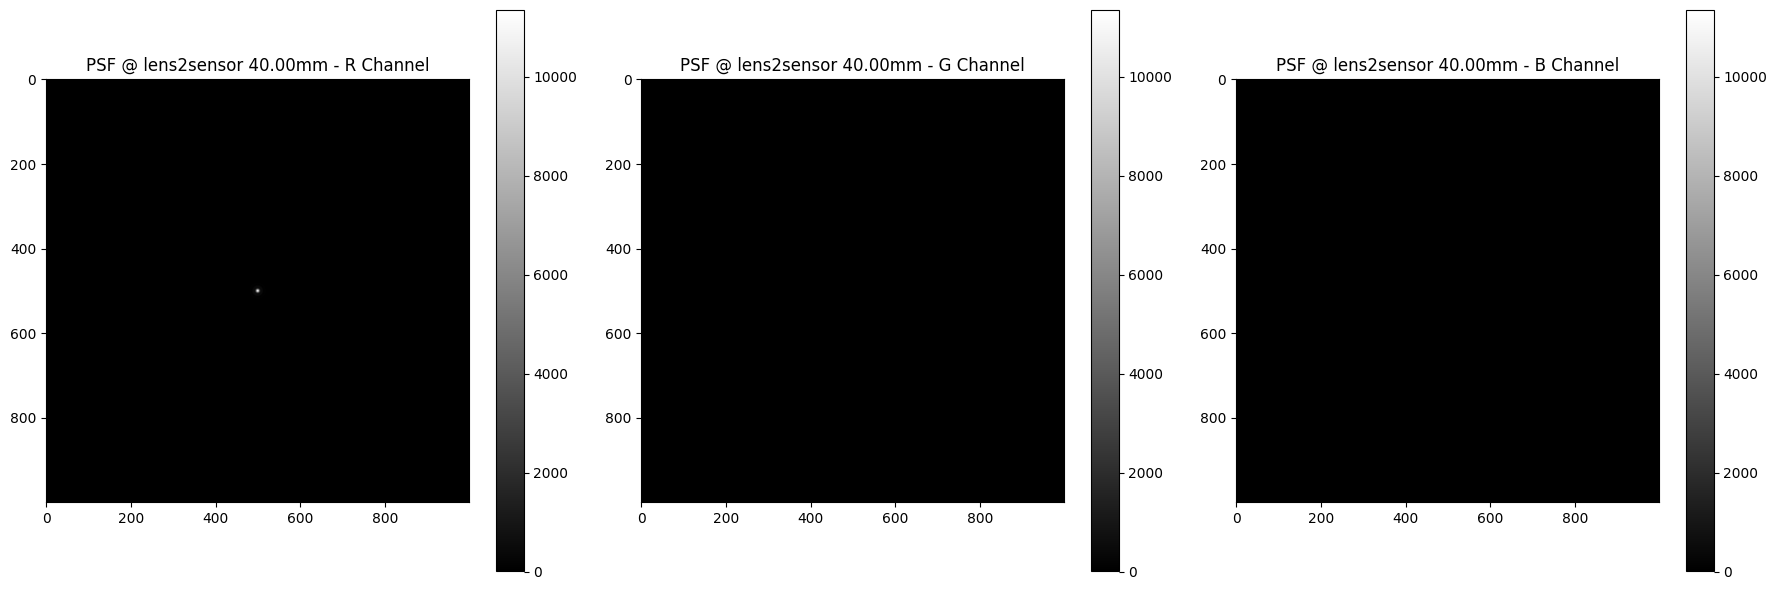

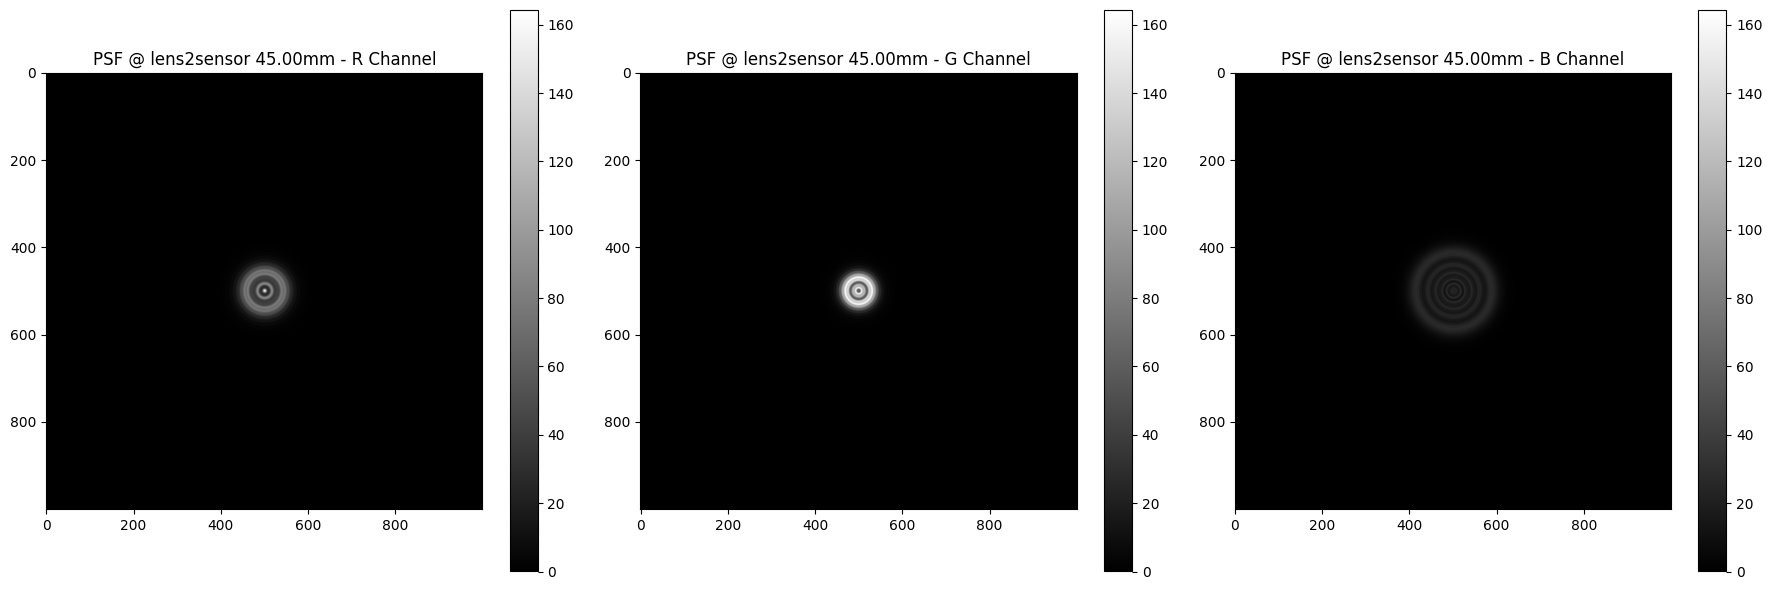

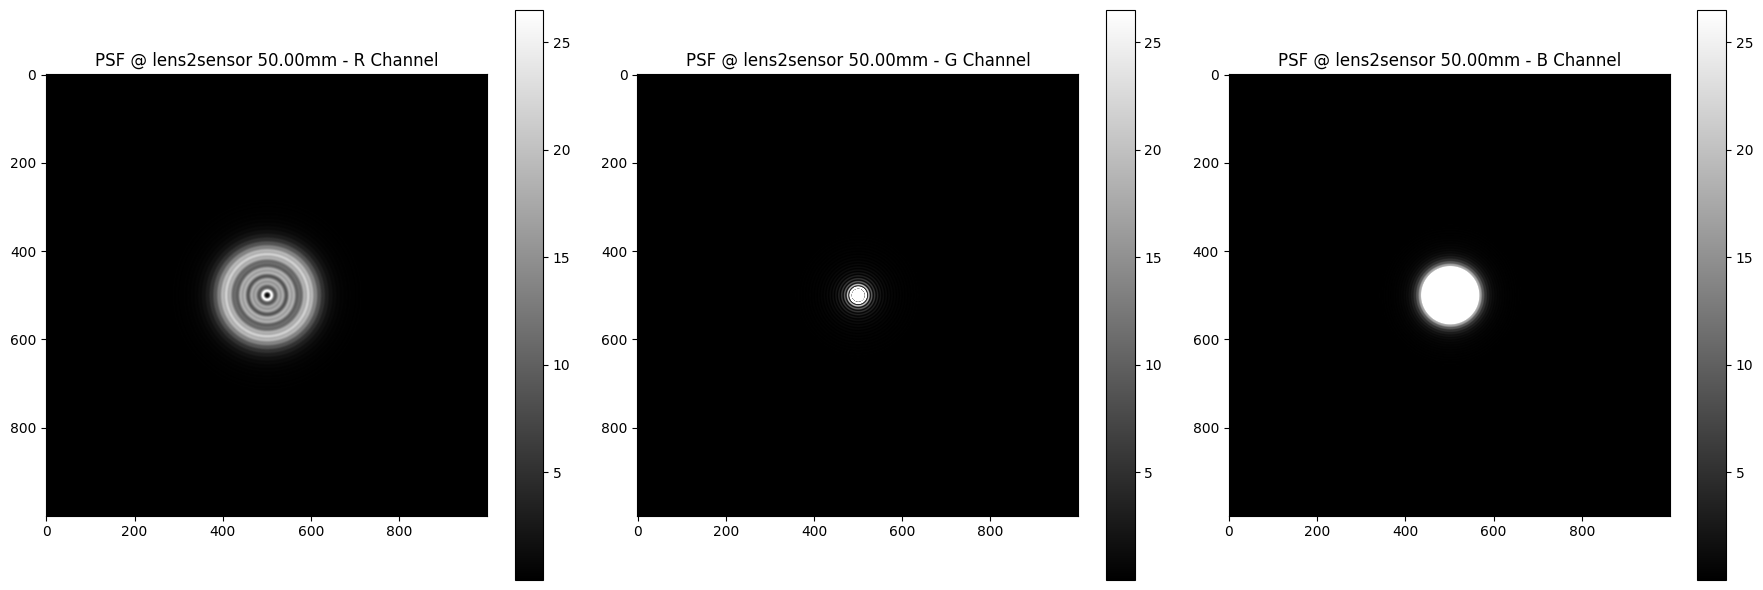

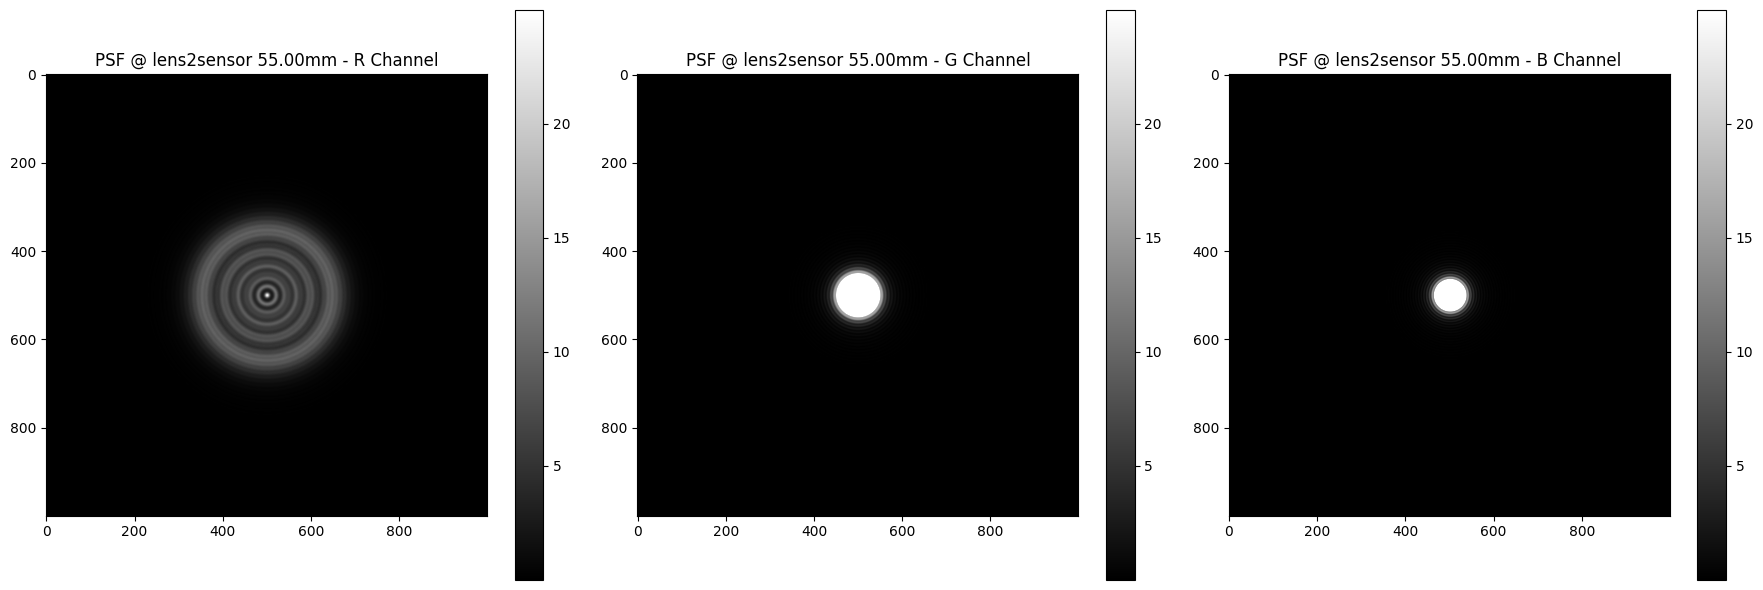

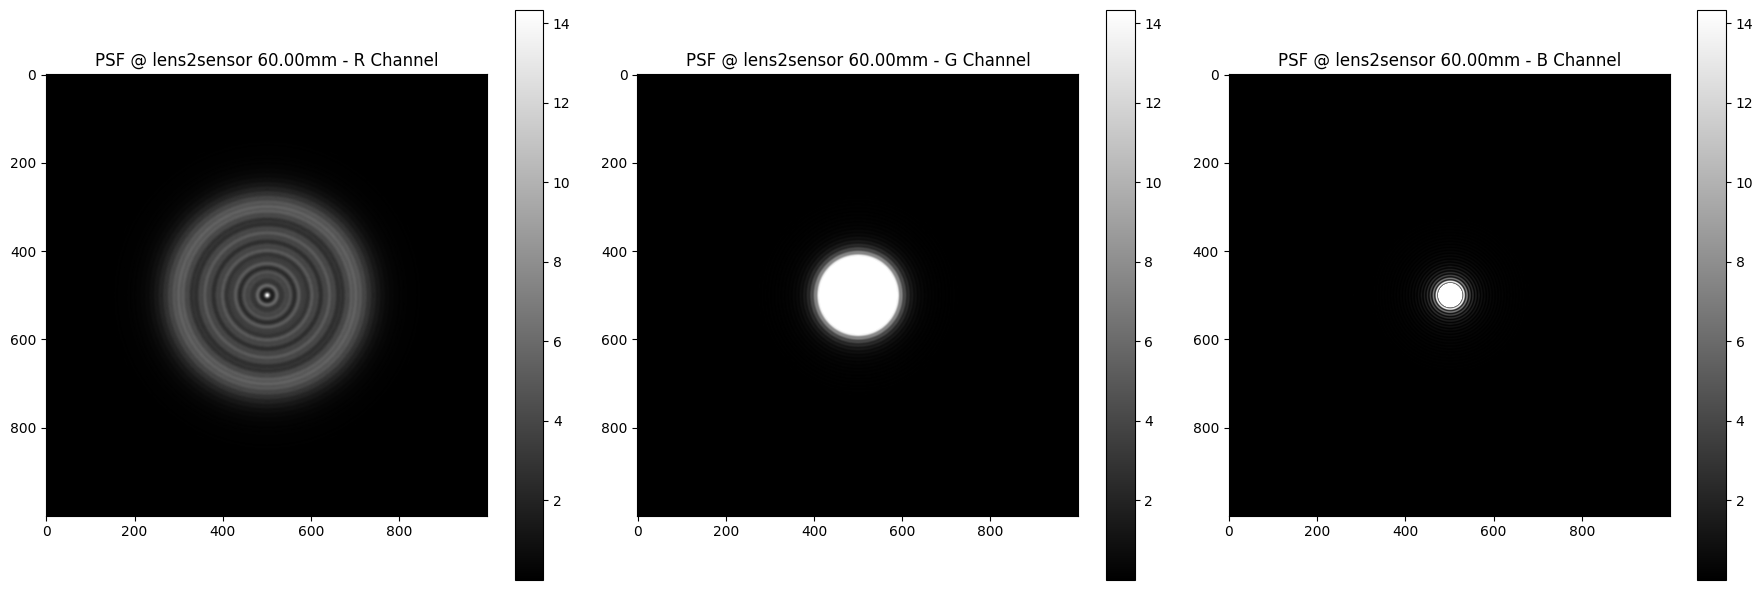

In [11]:
circular_aperture_change = aperture.get_amplitude_change()

for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, circular_aperture_change)

    channels = [('R', 0), ('G', 1), ('B', 2)]

    plt.figure(figsize=(18, 6))

    first_channel_PSF = PSF[:, channels[0][1], ...].data.cpu().squeeze()
    vmin, vmax = first_channel_PSF.min(), first_channel_PSF.max()

    for i, (color, idx) in enumerate(channels):
        plt.subplot(1, 3, i + 1)
        PSF_channel = PSF[:, idx, ...].data.cpu().squeeze()
        plt.imshow(PSF_channel, cmap='gray', vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title(f'PSF @ lens2sensor {lens2sensor_d*1e3:.2f}mm - {color} Channel')

    plt.tight_layout()
    plt.show()


## 🌈 **Step 5: Visualizing Chromatic Aberration**
Now, let's test a coded-aperture configuration, where a new amplitude modulation profile of the aperture is used. 

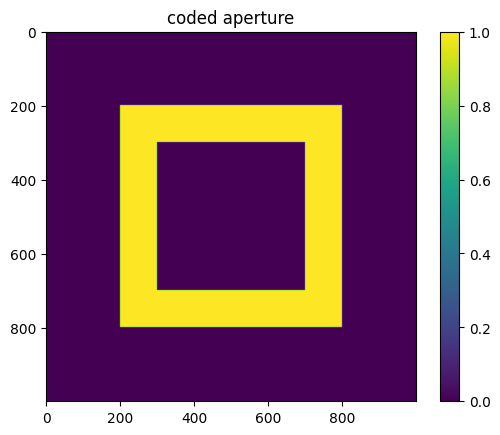

In [12]:
coded_pattern = torch.zeros((1,1,R,C), device=device)
thickness = 50
coded_pattern[0, 0, R//4-thickness:R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, 3*R//4-thickness:3*R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, C//4-thickness:C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, 3*C//4-thickness:3*C//4+thickness] = 1
plt.figure()
plt.imshow(coded_pattern.data.cpu().numpy().squeeze())
plt.title('coded aperture')
plt.colorbar()

Again, we simulate the PSF for the coded-aperture camera

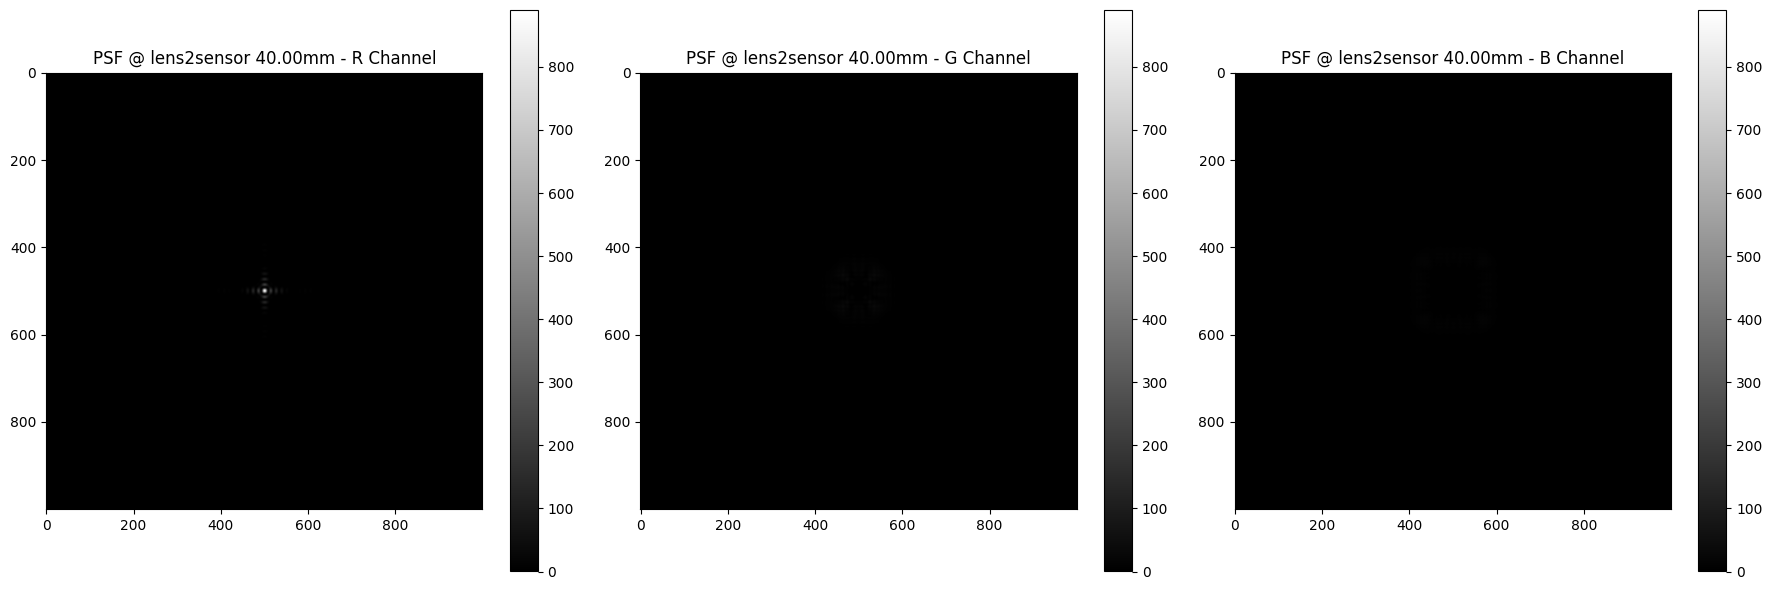

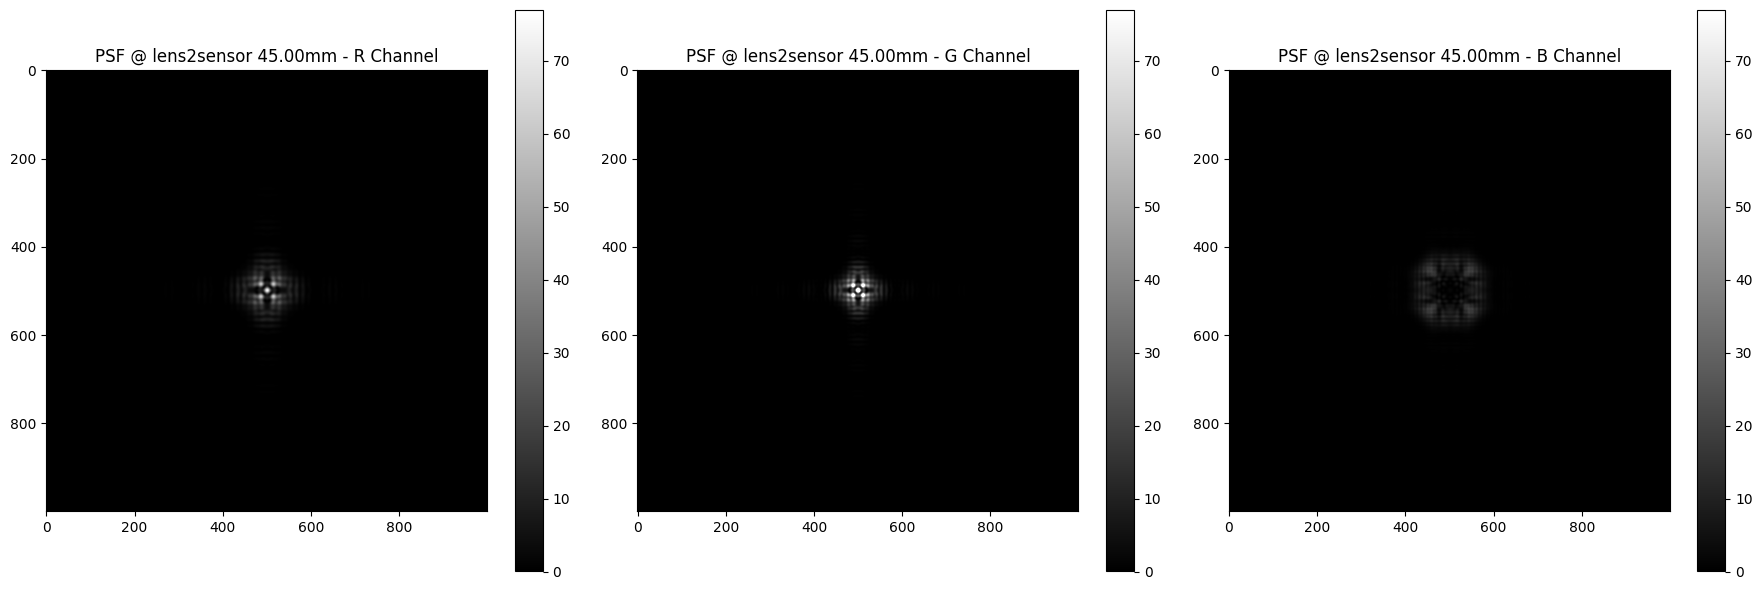

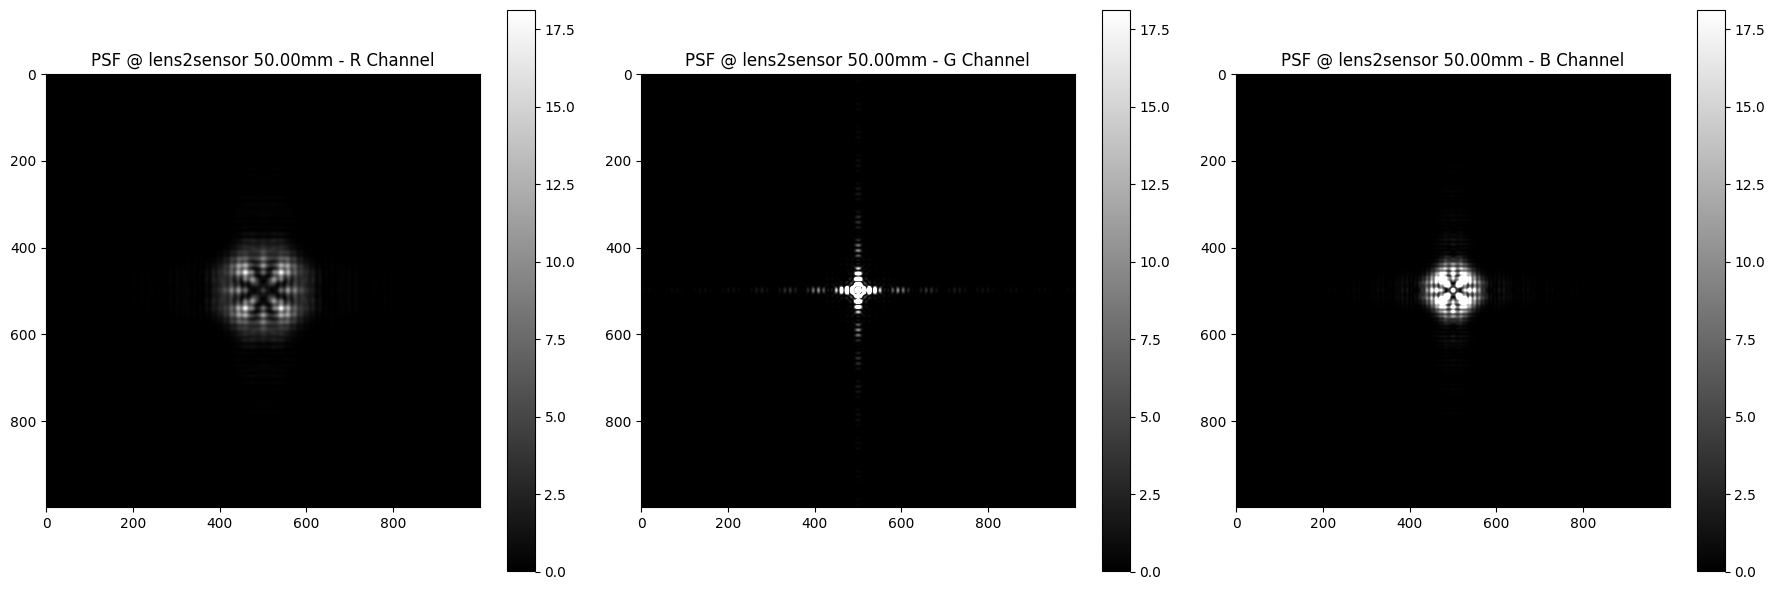

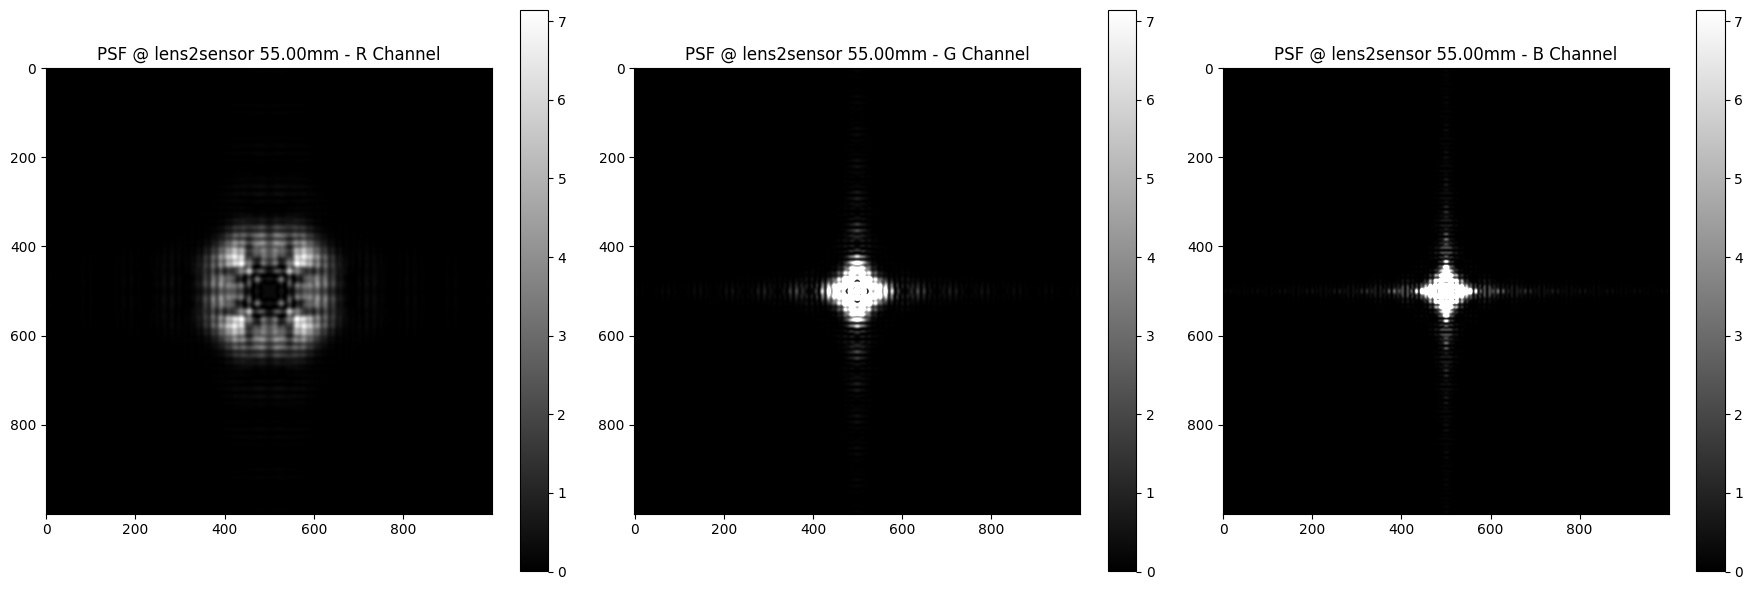

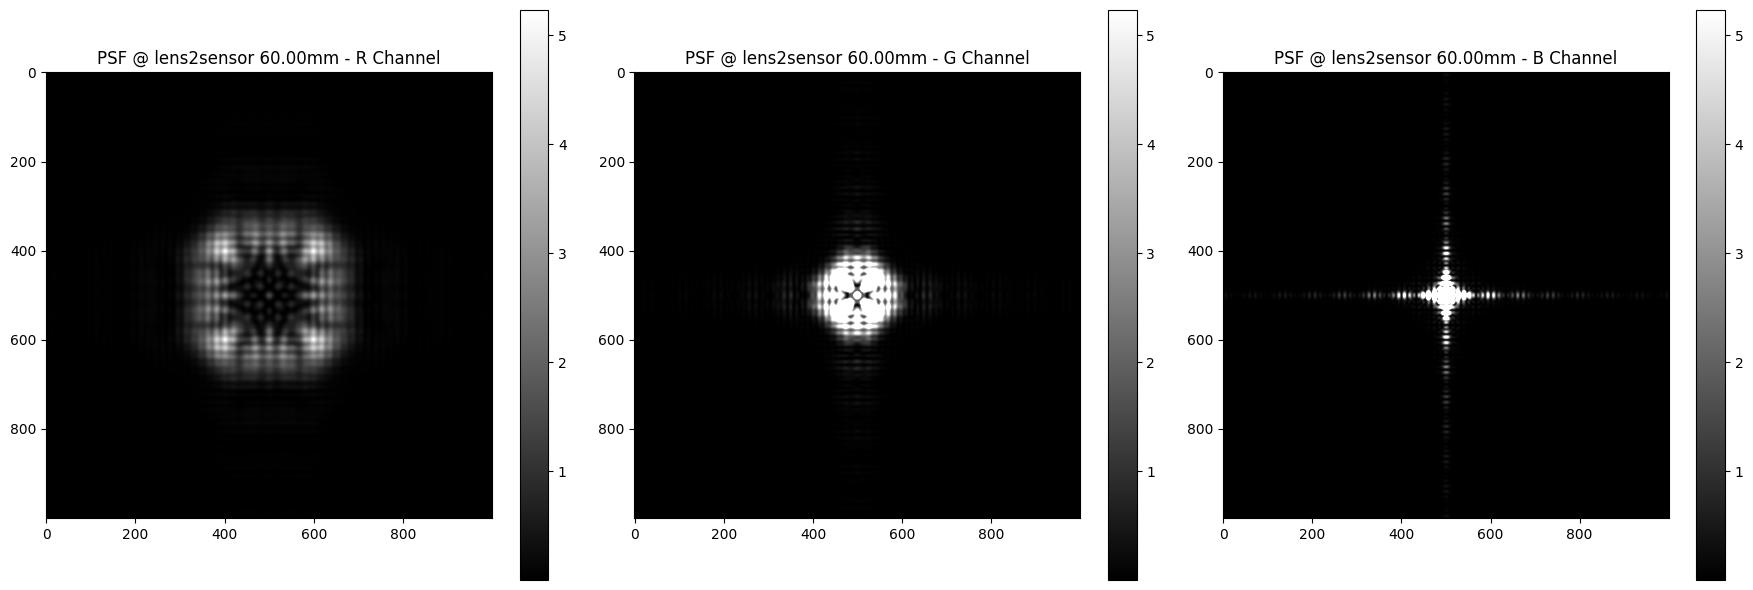

In [13]:
circular_aperture_change = aperture.get_amplitude_change()

for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, coded_pattern)

    channels = [('R', 0), ('G', 1), ('B', 2)]
    plt.figure(figsize=(18, 6))

    vmin = PSF[:, channels[0][1], ...].min()
    vmax = PSF[:, channels[0][1], ...].max()

    for i, (color, idx) in enumerate(channels):
        plt.subplot(1, 3, i + 1)
        PSF_channel = PSF[:, idx, ...].data.cpu().squeeze()
        plt.imshow(PSF_channel, cmap='gray', vmin=vmin.item(), vmax=vmax.item())
        
        plt.colorbar()
        plt.title(f'PSF @ lens2sensor {lens2sensor_d*1e3:.2f}mm - {color} Channel')

    plt.tight_layout()
    plt.show()
